In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
#import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [3]:

def add_layer(tensor):
    return tensor[0] + tensor[1]

def mul_layer(tensor):
    return tensor[0] * tensor[1]

def div_layer(tensor):
    return tensor[0] / tensor[1]

def sub_layer(tensor):
    return tensor[0] - tensor[1]

def neg_layer(tensor):
    return -tensor

def cos_layer(tensor):
    return tf.math.cos(tensor)

def sin_layer(tensor):
    return tf.math.sin(tensor)

# Model

In [4]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

# feature extraction from right image
right_img = Input(shape = (112,112,3), name="right_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

right_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=right_img, input_shape=(112,112,3))
right_phi_features = right_phi_model.output
right_flat = Flatten(name='right-phi-flattened')(right_phi_features)

concat = concatenate([left_flat, right_flat])

# fx
dense_1 = Dense(120, activation = 'relu')(concat)
dense_2 = Dense(84, activation = 'relu')(dense_1)
pred_fx = Dense(1, name='fx')(dense_2)

# fy
dense_3 = Dense(120, activation = 'relu')(concat)
dense_4 = Dense(84, activation = 'relu')(dense_3)
pred_fy = Dense(1, name='fy')(dense_4)

# u0
dense_5 = Dense(120, activation = 'relu')(concat)
dense_6 = Dense(84, activation = 'relu')(dense_5)
pred_u0 = Dense(1, name='u0')(dense_6)

# v0
dense_7 = Dense(120, activation = 'relu')(concat)
dense_8 = Dense(84, activation = 'relu')(dense_7)
pred_v0 = Dense(1, name='v0')(dense_8)

# baseline
dense_9 = Dense(120, activation = 'relu')(concat)
dense_10 = Dense(84, activation = 'relu')(dense_9)
pred_baseline = Dense(1, name='baseline')(dense_10)

# tx
dense_11 = Dense(120, activation = 'relu')(concat)
dense_12 = Dense(84, activation = 'relu')(dense_11)
pred_x = Dense(1, name='x')(dense_12)

# ty
dense_13 = Dense(120, activation = 'relu')(concat)
dense_14 = Dense(84, activation = 'relu')(dense_13)
pred_y = Dense(1, name='y')(dense_14)

# tz
dense_15 = Dense(120, activation = 'relu')(concat)
dense_16 = Dense(84, activation = 'relu')(dense_15)
pred_z = Dense(1, name='z')(dense_16)

# pitch
dense_17 = Dense(120, activation = 'relu')(concat)
dense_18 = Dense(84, activation = 'relu')(dense_17)
pred_pitch = Dense(1, name='pitch')(dense_18)

# u
dense_19 = Dense(120, activation = 'relu')(concat)
dense_20 = Dense(84, activation = 'relu')(dense_19)
pred_u = Dense(1, name='u')(dense_20)

# v
dense_21 = Dense(120, activation = 'relu')(concat)
dense_22 = Dense(84, activation = 'relu')(dense_21)
pred_v = Dense(1, name='v')(dense_22)

# disparity
dense_23 = Dense(120, activation = 'relu')(concat)
dense_24 = Dense(84, activation = 'relu')(dense_23)
pred_disparity = Dense(1, name='disparity')(dense_24)

# yWorld
dense_25 = Dense(120, activation = 'relu')(concat)
dense_26 = Dense(84, activation = 'relu')(dense_25)
pred_yWorld = Dense(1, name='yWorld')(dense_26)

# xWorld
dense_27 = Dense(120, activation = 'relu')(concat)
dense_28 = Dense(84, activation = 'relu')(dense_27)
pred_xWorld = Dense(1, name='xWorld')(dense_28)

# zWorld
dense_29 = Dense(120, activation = 'relu')(concat)
dense_30 = Dense(84, activation = 'relu')(dense_29)
pred_zWorld = Dense(1, name='zWorld')(dense_30)

# create model
model = Model(inputs=[left_img, right_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
plot_model(model, to_file='model.png')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 55, 55, 32)   864         right_image[0][0]                
_______________________________________________________________________________________

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Get data

In [5]:
data_path = "../Data/"

Left_images = np.load(data_path+"lir.npy")
Right_images = np.load(data_path+"rir.npy")
Fx = np.load(data_path+"fxr.npy")
Fy = np.load(data_path+"fyr.npy") 
U0 = np.load(data_path+"u0r.npy") 
V0 = np.load(data_path+"v0r.npy") 
Baseline = np.load(data_path+"br.npy")
Disparity = np.load(data_path+"dr.npy") 
Tx = np.load(data_path+"txr.npy") 
Ty = np.load(data_path+"tyr.npy") 
Tz = np.load(data_path+"tzr.npy") 
Pitch = np.load(data_path+"pr.npy")
X = np.load(data_path+"xr.npy")
Y = np.load(data_path+"yr.npy") 
Z = np.load(data_path+"zr.npy")


In [7]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
#from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20220112-160223/model_multi_class/Best/weights_03_17.17.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images, Right_images],
    batch_size=16,
    verbose=1
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [6]:
np.save("../Data/p_cplb_ad.npy", output)

In [8]:
np.shape(output)

(13, 2914, 1)

Text(0, 0.5, '% Correct')

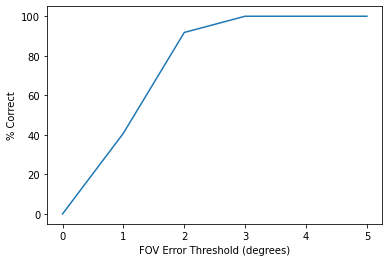

In [9]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 0

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [10]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 1190, 2675, 2914, 2914, 2914)

In [11]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 0.40837336993822926, 0.9179821551132464, 1.0)

In [8]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 2186.3670738864403, 'fy': 2187.1436920191013, 'u0': 984.6042726290606, 'v0': 473.20086944053617, 'baseline': 3.826180610311762, 'disparity': 27.03408578936172, 'x': 2.071062517681593, 'y': 4.118374694678255, 'z': 1.228950299822294, 'pitch': 53.201507159856355, 'xworld': 27.1764243272153, 'yworld': 51.49844793019755, 'zworld': 74.53145712470256}


# Normalization

In [6]:

import math 

def normalize(x):
    
    return (math.atan(x) + 3.14/2) / 3.14

In [7]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 1.0001079048283747, 'fy': 1.0001079550678076, 'u0': 0.9999301561826354, 'v0': 0.9995805925511179, 'baseline': 0.9150464332357404, 'disparity': 0.9847411736631334, 'x': 0.8446278877259601, 'y': 0.9233048726947141, 'z': 0.7739204234938659, 'pitch': 0.9920591301015977, 'xworld': 0.9437669502243071, 'yworld': 0.9932035654804066, 'zworld': 0.9944197106361}


# Range Normalization

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

min_fx = 1373.2275
max_fx = 2269.381661995158

min_fy = 1520.9558
max_fy = 2268.491

min_u0 = 382.5896
max_u0 = 1010.2414896422663

min_v0 = 33.014587
max_v0 = 504.2467619374397

min_baseline = 0.01699097
max_baseline = 23.478404679970208

min_disparity = 0.00021930835792538517
max_disparity = 88.691475

min_tx = 2.6702880859375e-05
max_tx = 21.68721567997021

min_ty = 0.8303014
max_ty = 33.99193576309983

min_tz = 0.0011047315597534357
max_tz = 16.97185265614626

min_pitch = 10.154588
max_pitch = 790.04095

min_xw = 0.00066566
max_xw = 6457.3228

min_yw = 0.0036399107805458186
max_yw = 2944.4214

min_zw = 0.01162195
max_zw = 1391.999

key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.9073657218933816, 'fy': 0.8911792863189639, 'u0': 0.959153764151151, 'v0': 0.9341176300646369, 'baseline': 0.162359766113543, 'disparity': 0.304808701513457, 'x': 0.0954958160669061, 'y': 0.09915293342707354, 'z': 0.072350706217905, 'pitch': 0.05519639573353677, 'xworld': 0.004208518222385353, 'yworld': 0.017488961213507317, 'zworld': 0.053534851802235356}


# Normalized MAE

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 2282.8645019999262

mean_fy = 2281.794340454267

mean_u0 = 1042.0412599999809

mean_v0 = 529.8880620000258

mean_baseline = 0.20881100000000483

mean_disparity = 21.47887086050103

mean_tx = 2.0

mean_ty = 0.125

mean_tz = 1.2300000000000164

mean_pitch = 0.0219999999999989

mean_xw = 42.289555967764755

mean_yw = 18.34660238283241

mean_zw = 9.56192501636253


key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx 
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.9577296719374738, 'fy': 0.95851920125069, 'u0': 0.9448803137010643, 'v0': 0.8930204385553603, 'baseline': 18.323654354255485, 'disparity': 1.2586362646856004, 'x': 1.0355312493498716, 'y': 32.94699771026266, 'z': 0.9991465944342491, 'pitch': 2418.2502467834565, 'xworld': 0.6426273231157257, 'yworld': 2.8069746502315494, 'zworld': 7.794608172093778}


In [7]:
np.shape(output)

(13, 2914, 1)

In [8]:
k

2914

In [9]:
sum(error.values())

5.1366481177233325